# Data Exploration

## Initialize Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from varclushi import VarClusHi


In [2]:
# plot defaults
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Target Variable Analysis

Our target variable is the expected loss per policy normalized by exposure: Expected Loss = Claim Cost (claimcst0) / Exposure

In [4]:
model_data = pd.read_csv('../backend/model_data.csv')
inference_data = pd.read_csv('../backend/inference_data.csv')

In [5]:
model_data['expected_loss'] = model_data['claimcst0'] / model_data['exposure']

## Visualize Frequency & Severity of Claims

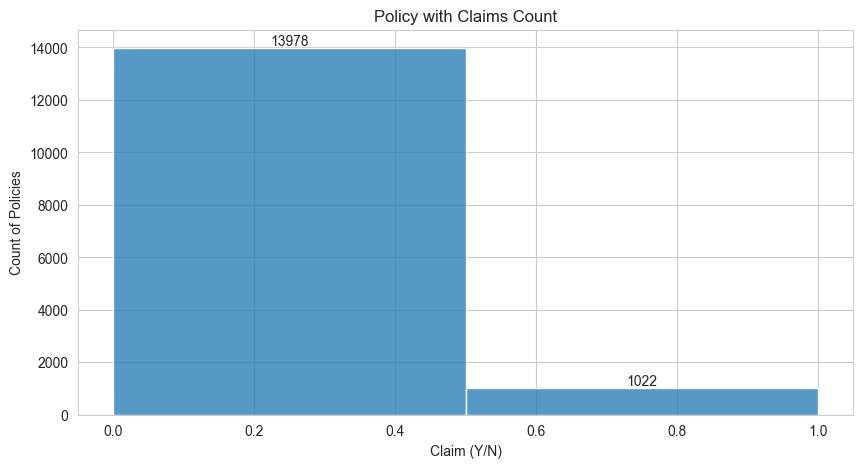

Base Claim Rate (Frequency): 6.81%


In [9]:
# Histogram of claim cost
plt.figure(figsize=(10, 6))
ax = sns.histplot(model_data['clm'], bins=2, kde=False)
for p in ax.patches:
    height = p.get_height()
    if height > 0: # Only annotate non-empty bins
        ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.1, # Adjust vertical position
            f'{int(height)}', # Format the count as an integer
            ha='center', va='bottom', fontsize=10)
plt.title('Policy with Claims Count')
plt.xlabel('Claim (Y/N)')
plt.ylabel('Count of Policies')
plt.show()

claim_rate = model_data['clm'].mean()
print(f"Base Claim Rate (Frequency): {claim_rate:.2%}")


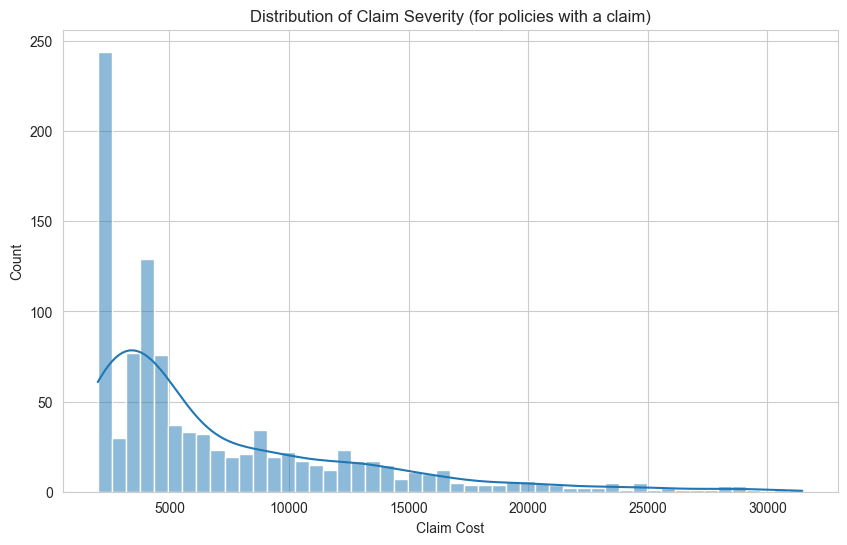

Average Claim Severity (cost when clm=1): $7,000.19


In [10]:
# Analyze severity (cost given a claim happened)
severity_df = model_data[model_data['clm'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(severity_df['claimcst0'], bins=50, kde=True)
plt.title('Distribution of Claim Severity (for policies with a claim)')
plt.xlabel('Claim Cost')
plt.show()

print(f"Average Claim Severity (cost when clm=1): ${severity_df['claimcst0'].mean():,.2f}")

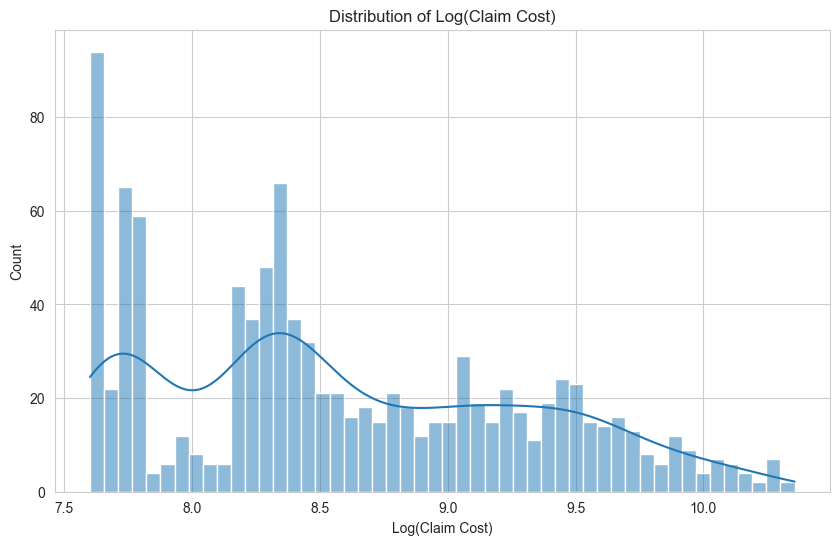

In [18]:
# Log-transform for a clearer view
plt.figure(figsize=(10, 6))
sns.histplot(np.log(severity_df['claimcst0']), bins=50, kde=True)
plt.title('Distribution of Log(Claim Cost)')
plt.xlabel('Log(Claim Cost)')
plt.show()

## Visualizing Predictors

In [20]:
# Identifying feature by type (numerical vs categorical)
num_features = [
    'exposure',
    'veh_value',
    'max_power',
    'driving_history_score',
    'credit_score'
]

cat_features = [
    'veh_age',
    'area',
    'veh_body',
    'gender',
    'agecat',
    'engine_type',
    'veh_color',
    'marital_status',
    'e_bill',
    'time_of_week_driven',
    'time_driven',
    'trm_len',
    'low_education_ind'
]

possible_target_features = [
    'clm',
    'numclaims',
    'claimcst0',
    'expected_loss'
]

# Make sure columns exist (aka no typos)
features = [col for col in num_features + cat_features if col in model_data.columns]
num_features = [col for col in num_features if col in model_data.columns]
cat_features = [col for col in cat_features if col in model_data.columns]

print(f"Found {len(features)} features: {features}")

Found 18 features: ['exposure', 'veh_value', 'max_power', 'driving_history_score', 'credit_score', 'veh_age', 'area', 'veh_body', 'gender', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'low_education_ind']


## Target Encoding

## Check Variable Collinearity and Relationships

## Save Altered Data

In [11]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)